In [2]:
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import dask.array as da
import dask.dataframe as dd
import xarray as xr
from xnemogcm import open_domain_cfg, get_metrics
import xgcm
import cartopy.crs as ccrs
import cmocean
import numpy as np
from scipy.stats import linregress
import datetime
import pandas as pd
import plots_spatial as pltspat
# Add SouthernDemons library to PATH
sys.path.append(os.path.abspath("../lib/"))
from teos_ten import teos_sigma0
import datesandtime

In [3]:
# Subdomain information (As inputted into TRACMASS, note non-pythonic indexing)
imindom = 1
imaxdom = 1440
jmindom = 1
jmaxdom = 400
kmindom = 1
kmaxdom = 75

# Location of the TRACMASS run
data_dir = os.path.abspath("/gws/nopw/j04/bas_pog/astyles/ORCA025_fwd/")

# Location of the OUTPUT directory created when running SouthernDemons executable
out_dir = os.path.abspath(data_dir + "/OUTPUT.ORCA025_fwd/")

# Location of masks and grid information for the model
grid_path = os.path.abspath("/gws/nopw/j04/bas_pog/astyles/ORCA025_fwd/topo" )
grid_files = ['mask.nc','mesh_hgr.nc','mesh_zgr.nc']
# mask_path = os.path.abspath("/gws/nopw/j04/aopp/astyles/TRACMASS_DATA/DRAKKAR_SET/ORCA025/topo/mask.nc")
# hgrid_path = os.path.abspath("/gws/nopw/j04/aopp/astyles/TRACMASS_DATA/DRAKKAR_SET/ORCA025/topo/mesh_hgr.nc")
# zgrid_path = os.path.abspath("/gws/nopw/j04/aopp/astyles/TRACMASS_DATA/DRAKKAR_SET/ORCA025/topo/mesh_zgr.nc")

cal_months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

In [4]:
# Use dask to load the tabulated data lazily 
df_ini = dd.read_parquet(out_dir + f"/df_ini.combined.parquet")
df_out = dd.read_parquet(out_dir + f"/df_out.combined.parquet")
df_vent = dd.read_parquet(out_dir + f"/df_vent.parquet")


In [5]:
ds_domain = open_domain_cfg( datadir=grid_path, files = grid_files )

In [5]:
ds_domain

<xarray.Dataset> Size: 6GB
Dimensions:       (y_c: 1021, x_c: 1442, x_f: 1442, y_f: 1021, z_c: 75, z_f: 75)
Coordinates: (12/18)
    glamt         (y_c, x_c) float32 6MB dask.array<chunksize=(128, 91), meta=np.ndarray>
    glamu         (y_c, x_f) float32 6MB dask.array<chunksize=(128, 91), meta=np.ndarray>
    glamv         (y_f, x_c) float32 6MB dask.array<chunksize=(128, 91), meta=np.ndarray>
    glamf         (y_f, x_f) float32 6MB dask.array<chunksize=(128, 91), meta=np.ndarray>
    gphit         (y_c, x_c) float32 6MB dask.array<chunksize=(128, 91), meta=np.ndarray>
    gphiu         (y_c, x_f) float32 6MB dask.array<chunksize=(128, 91), meta=np.ndarray>
    ...            ...
  * x_f           (x_f) float64 12kB 0.5 1.5 2.5 ... 1.44e+03 1.44e+03 1.442e+03
  * y_f           (y_f) float64 8kB 0.5 1.5 2.5 ... 1.018e+03 1.02e+03 1.02e+03
  * z_f           (z_f) float64 600B -0.5 0.5 1.5 2.5 ... 70.5 71.5 72.5 73.5
  * x_c           (x_c) int64 12kB 0 1 2 3 4 5 ... 1436 1437 1438 1439 1440 1441
  * y_c           (y_c) int64 8kB 0 1 2 3 4 5 ... 1015 1016 1017 1018 1019 1020
  * z_c           (z_c) int64 600B 0 1 2 3 4 5 6 7 8 ... 67 68 69 70 71 72 73 74
Data variables: (12/29)
    time_counter  float64 8B dask.array<chunksize=(), meta=np.ndarray>
    e1t           (y_c, x_c) float64 12MB dask.array<chunksize=(128, 91), meta=np.ndarray>
    e1u           (y_c, x_f) float64 12MB dask.array<chunksize=(128, 91), meta=np.ndarray>
    e1v           (y_f, x_c) float64 12MB dask.array<chunksize=(128, 91), meta=np.ndarray>
    e1f           (y_f, x_f) float64 12MB dask.array<chunksize=(128, 91), meta=np.ndarray>
    e2t           (y_c, x_c) float64 12MB dask.array<chunksize=(128, 91), meta=np.ndarray>
    ...            ...
    vmask         (z_c, y_f, x_c) int8 110MB dask.array<chunksize=(5, 128, 91), meta=np.ndarray>
    fmask         (z_c, y_f, x_f) int8 110MB dask.array<chunksize=(5, 128, 91), meta=np.ndarray>
    tmaskutil     (y_c, x_c) int8 1MB dask.array<chunksize=(128, 91), meta=np.ndarray>
    umaskutil     (y_c, x_f) int8 1MB dask.array<chunksize=(128, 91), meta=np.ndarray>
    vmaskutil     (y_f, x_c) int8 1MB dask.array<chunksize=(128, 91), meta=np.ndarray>
    fmaskutil     (y_f, x_f) int8 1MB dask.array<chunksize=(128, 91), meta=np.ndarray>
Attributes:
    DOMAIN_size_global:  [1442 1021]

In [8]:
df_vent.head(10)

ntraj_o      x_o     y_o    z_o      subvol_o     time_o  boxface_o  \
0     4224  1200.18  334.99  17.85  7.620966e+08  302400.00          0   
1   635086  1198.02  319.50  14.50  6.773663e+08    4320.00          0   
2   637567  1200.08  296.18  18.49  8.949214e+08    4320.00          0   
3   637708  1199.92  328.44  19.27  8.048074e+08  315360.00          0   
4   638841  1199.99  329.18  19.79  8.782379e+08  285120.00          0   
5     6206  1197.67  288.65  19.32  9.348586e+08  436320.00          0   
6     6207  1196.26  289.06  19.19  9.348586e+08  436320.00          0   
7     7463  1198.84  284.43  20.86  9.847415e+08  436320.00          0   
8     8846  1199.00  280.42  20.99  7.964010e+08  638443.82          1   
9     8905  1199.04  304.11  21.55  9.019966e+08  436320.00          0   

   temp_o  sal_o  density_o  ...  year_o  month_o  day_o  dayofyear_o  \
0   15.93  35.43      25.96  ...    1982       12     19          353   
1   11.43  34.64      26.29  ...    1982       12     16          350   
2    9.66  34.37      26.39  ...    1982       12     16          350   
3   15.42  35.35      26.02  ...    1982       12     19          353   
4   15.80  35.44      26.00  ...    1982       12     19          353   
5    7.21  34.09      26.55  ...    1982       12     21          355   
6    7.37  34.11      26.54  ...    1982       12     21          355   
7    6.27  33.99      26.60  ...    1982       12     21          355   
8    6.35  34.01      26.60  ...    1982       12     23          357   
9   10.55  34.70      26.50  ...    1982       12     21          355   

   binnedx_i  binnedy_i  binnedz_i  binnedx_o  binnedy_o  binnedz_o  
0       1200        335         17       1200        335         18  
1       1198        319         14       1198        319         14  
2       1200        296         18       1200        296         18  
3       1200        327         19       1200        328         19  
4       1200        328         20       1200        329         20  
5       1198        289         19       1198        289         19  
6       1198        289         19       1196        289         19  
7       1200        284         20       1199        284         21  
8       1200        284         21       1199        280         21  
9       1200        304         22       1199        304         22  

[10 rows x 37 columns]

In [6]:
# Isolate the necessary fields (month_o, subvol_o)
df = df_vent[['binnedx_o','binnedy_o','subvol_o']]
#df = df[ (df['binnedx_o']>1300)]

# Group together data which ventilated in the same horizontal grid cell (same combination of binnedx and binnedy)
df_group = df.groupby( ['binnedx_o','binnedy_o'])

# Calculate total volume in each grid cell
vol_xy = df_group.sum("subvol_o").compute()

vol_xy.head(n=3)


subvol_o
binnedx_o binnedy_o              
1         111        2.487201e+10
          112        4.659052e+10
          115        2.243758e+10

In [7]:
da_vol_xy = vol_xy.to_xarray()["subvol_o"]

# Define coordinates x_c and y_c which are the Pythonic indices rather than the TRACMASS indices. This ensures agreement with the coordinates for ds_domain
da_vol_xy = da_vol_xy.assign_coords( {'x_c':da_vol_xy.binnedx_o - 1, 'y_c':da_vol_xy.binnedy_o - 1} ) 
da_vol_xy = da_vol_xy.swap_dims({'binnedx_o':'x_c', 'binnedy_o':'y_c'})

# Reorder axes to agree with ds_subdomain
da_vol_xy = da_vol_xy.transpose("y_c","x_c",...)


# Align the coordinates of the grid file with the subdomain in da_vol_xy
ds_domain_allign, da_vol_xy = xr.align( ds_domain, da_vol_xy )

In [8]:
type(da_vol_xy)

xarray.core.dataarray.DataArray

In [9]:
vol_xy

subvol_o
binnedx_o binnedy_o              
1         111        2.487201e+10
          112        4.659052e+10
          115        2.243758e+10
          116        3.255102e+10
          121        9.415982e+10
...                           ...
984       2          1.277682e+08
1238      354        9.809153e+08
1292      114        2.396079e+08
1334      129        8.383056e+08
          301        9.826092e+08

[439981 rows x 1 columns]

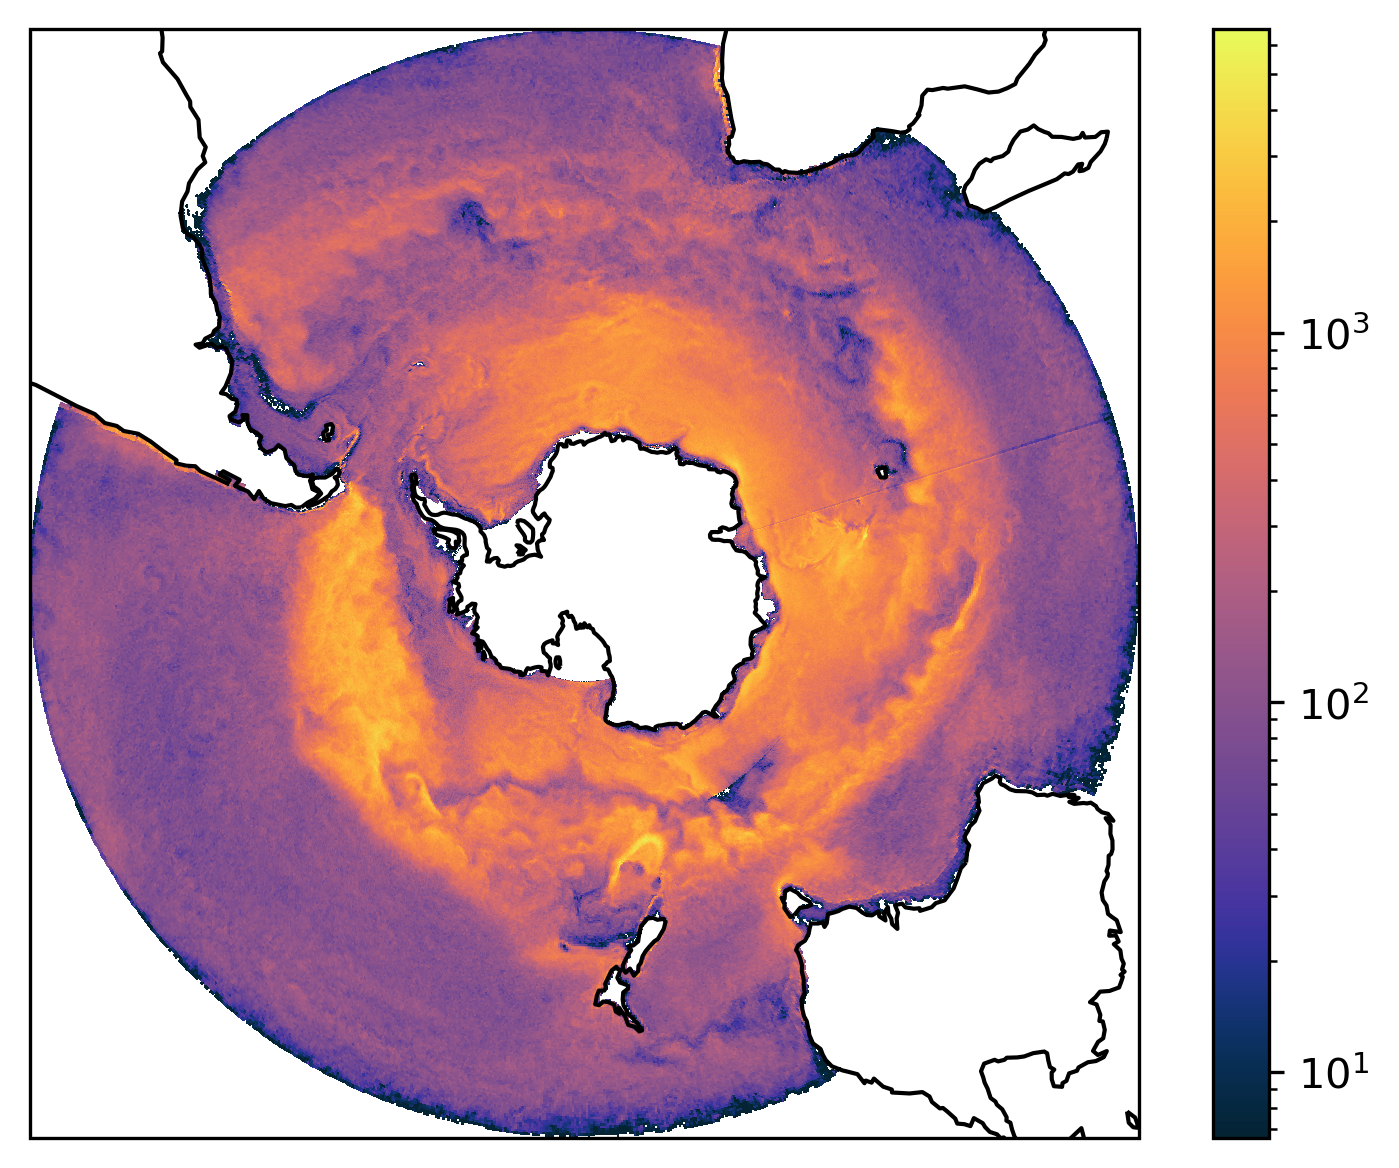

In [10]:
fig, ax = plt.subplots(1,1,dpi=300,subplot_kw={'projection':ccrs.SouthPolarStereo()})
lat = ds_domain_allign.gphit
lon = ds_domain_allign.glamt
xs = ds_domain_allign.e1t
ys =  ds_domain_allign.e2t
areas = xs*ys

vnorm = da_vol_xy/areas
vmax = vnorm.max().compute()

lognorm = matplotlib.colors.LogNorm(vmax = vmax, vmin = vmax /1e3 )
cax = ax.pcolormesh( lon, lat, da_vol_xy/areas, transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, norm=lognorm )
ax.coastlines()
fig.colorbar(cax)



In [33]:
### Seasonal locations of ventilation

In [13]:
df = df_vent[['binnedx_o','binnedy_o','subvol_o','month_o']]
df = df[df['month_o']==1]
#df = df[ (df['binnedx_o']>1300)]

# Group together data which ventilated in the same horizontal grid cell (same combination of binnedx and binnedy)
df_group = df.groupby( ['binnedx_o','binnedy_o','month_o'])

# Calculate total volume in each grid cell
vol_xy = df_group.sum("subvol_o").compute()
vol_xy.head(n=3)


subvol_o
binnedx_o binnedy_o month_o              
1         123       1        2.444427e+09
          127       1        3.473649e+09
          171       1        3.120918e+09

In [11]:
type(df)

dask.dataframe.dask_expr._collection.DataFrame

In [7]:
def plot_norm(ds_domain, vol_xy, y): 
    #print((vol_xy.head(5)))
    da_vol_xy = vol_xy.to_xarray()[f"{y}"]
    #print(da_vol_xy.head(4))
    # Define coordinates x_c and y_c which are the Pythonic indices rather than the TRACMASS indices. This ensures agreement with the coordinates for ds_domain
  
    da_vol_xy = da_vol_xy.assign_coords( {'x_c':da_vol_xy.binnedx_o - 1, 'y_c':da_vol_xy.binnedy_o - 1} ) 
    da_vol_xy = da_vol_xy.swap_dims({'binnedx_o':'x_c', 'binnedy_o':'y_c'})
    
    # Reorder axes to agree with ds_subdomain
    da_vol_xy = da_vol_xy.transpose("y_c","x_c",...)
    
    
    # Align the coordinates of the grid file with the subdomain in da_vol_xy
    ds_domain_allign, da_vol_xy = xr.align( ds_domain, da_vol_xy )

    fig, ax = plt.subplots(1,1,dpi=300,subplot_kw={'projection':ccrs.SouthPolarStereo()})
    lat = ds_domain_allign.gphit
    lon = ds_domain_allign.glamt
    xs = ds_domain_allign.e1t
    ys =  ds_domain_allign.e2t
    areas = xs*ys
    
    vnorm = da_vol_xy/areas
    vmax = vnorm.max().compute()
    
    lognorm = matplotlib.colors.LogNorm(vmax = 10**(3.5), vmin = vmax /1e4 )
    cax = ax.pcolormesh( lon, lat, vnorm, transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, norm=lognorm )
    ax.coastlines()
    fig.colorbar(cax)
    return fig ,ax

In [8]:
def plot(ds_domain, vol_xy, y,vmax=1e3): 
    #print((vol_xy.head(5)))
    da_vol_xy = vol_xy.to_xarray()[y]
    #print(da_vol_xy.head(4))
    # Define coordinates x_c and y_c which are the Pythonic indices rather than the TRACMASS indices. This ensures agreement with the coordinates for ds_domain
  
    da_vol_xy = da_vol_xy.assign_coords( {'x_c':da_vol_xy.binnedx_o - 1, 'y_c':da_vol_xy.binnedy_o - 1} ) 
    da_vol_xy = da_vol_xy.swap_dims({'binnedx_o':'x_c', 'binnedy_o':'y_c'})
    
    # Reorder axes to agree with ds_subdomain
    da_vol_xy = da_vol_xy.transpose("y_c","x_c",...)
    
    
    # Align the coordinates of the grid file with the subdomain in da_vol_xy
    ds_domain_allign, da_vol_xy = xr.align( ds_domain, da_vol_xy )

    fig, ax = plt.subplots(1,1,dpi=200,subplot_kw={'projection':ccrs.SouthPolarStereo()})
    lat = ds_domain_allign.gphit
    lon = ds_domain_allign.glamt
    
    
    
    #vmax = vnorm.max().compute()

    
    vmin=vmax*1e-4    
    lognorm = matplotlib.colors.LogNorm(vmax = vmax, vmin = vmin )
    cax = ax.pcolormesh( lon, lat, da_vol_xy, transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, norm=lognorm )
    ax.coastlines()
    fig.colorbar(cax)
    return fig ,ax

In [7]:
'''
# Isolate the necessary fields (month_o, subvol_o)
df = df_vent[df_vent['month_o'] ==9]
df = df[['binnedx_o','binnedy_o','subvol_o']]

# Group together data which ventilated in the same horizontal grid cell (same combination of binnedx and binnedy)
df_group = df.groupby( ['binnedx_o','binnedy_o'])

# Calculate total volume in each grid cell
vol_xy = df_group.sum("subvol_o").compute()

vol_xy.head(n=3)

da_vol_xy = vol_xy.to_xarray()["subvol_o"]

# Define coordinates x_c and y_c which are the Pythonic indices rather than the TRACMASS indices. This ensures agreement with the coordinates for ds_domain
da_vol_xy = da_vol_xy.assign_coords( {'x_c':da_vol_xy.binnedx_o - 1, 'y_c':da_vol_xy.binnedy_o - 1} ) 
da_vol_xy = da_vol_xy.swap_dims({'binnedx_o':'x_c', 'binnedy_o':'y_c'})

# Reorder axes to agree with ds_subdomain
da_vol_xy = da_vol_xy.transpose("y_c","x_c",...)


# Align the coordinates of the grid file with the subdomain in da_vol_xy
ds_domain_allign, da_vol_xy = xr.align( ds_domain, da_vol_xy )


fig, ax = plt.subplots(1,1,dpi=300,subplot_kw={'projection':ccrs.SouthPolarStereo()})
lat = ds_domain_allign.gphit
lon = ds_domain_allign.glamt
xs = ds_domain_allign.e1t
ys =  ds_domain_allign.e2t
areas = xs*ys

vnorm = da_vol_xy/areas
vmax = vnorm.max().compute()

lognorm = matplotlib.colors.LogNorm(vmax = vmax, vmin = vmax /1e3 )
cax = ax.pcolormesh( lon, lat, da_vol_xy/areas, transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, norm=lognorm )
ax.coastlines()
fig.colorbar(cax)
'''

'\n# Isolate the necessary fields (month_o, subvol_o)\ndf = df_vent[df_vent[\'month_o\'] ==9]\ndf = df[[\'binnedx_o\',\'binnedy_o\',\'subvol_o\']]\n\n# Group together data which ventilated in the same horizontal grid cell (same combination of binnedx and binnedy)\ndf_group = df.groupby( [\'binnedx_o\',\'binnedy_o\'])\n\n# Calculate total volume in each grid cell\nvol_xy = df_group.sum("subvol_o").compute()\n\nvol_xy.head(n=3)\n\nda_vol_xy = vol_xy.to_xarray()["subvol_o"]\n\n# Define coordinates x_c and y_c which are the Pythonic indices rather than the TRACMASS indices. This ensures agreement with the coordinates for ds_domain\nda_vol_xy = da_vol_xy.assign_coords( {\'x_c\':da_vol_xy.binnedx_o - 1, \'y_c\':da_vol_xy.binnedy_o - 1} ) \nda_vol_xy = da_vol_xy.swap_dims({\'binnedx_o\':\'x_c\', \'binnedy_o\':\'y_c\'})\n\n# Reorder axes to agree with ds_subdomain\nda_vol_xy = da_vol_xy.transpose("y_c","x_c",...)\n\n\n# Align the coordinates of the grid file with the subdomain in da_vol_xy\nds

In [ ]:
df = df_vent[df_vent['month_o'] ==1]
df = df[['binnedx_o','binnedy_o','subvol_o']]


In [9]:
'''
for i in range(12):
    df = df_vent[df_vent['month_o'] ==i+1]
    df = df[['binnedx_o','binnedy_o','subvol_o']]
    # Group together data which ventilated in the same horizontal grid cell (same combination of binnedx and binnedy)
    df_group = df.groupby( ['binnedx_o','binnedy_o'])
    # Calculate total volume in each grid cell
    vol_xy = df_group.sum("subvol_o").compute()
    plot_norm(ds_domain, vol_xy,'subvol_o')
    plt.plot()

'''

'\nfor i in range(12):\n    df = df_vent[df_vent[\'month_o\'] ==i+1]\n    df = df[[\'binnedx_o\',\'binnedy_o\',\'subvol_o\']]\n    # Group together data which ventilated in the same horizontal grid cell (same combination of binnedx and binnedy)\n    df_group = df.groupby( [\'binnedx_o\',\'binnedy_o\'])\n    # Calculate total volume in each grid cell\n    vol_xy = df_group.sum("subvol_o").compute()\n    plot_norm(ds_domain, vol_xy,\'subvol_o\')\n    plt.plot()\n\n'

[]

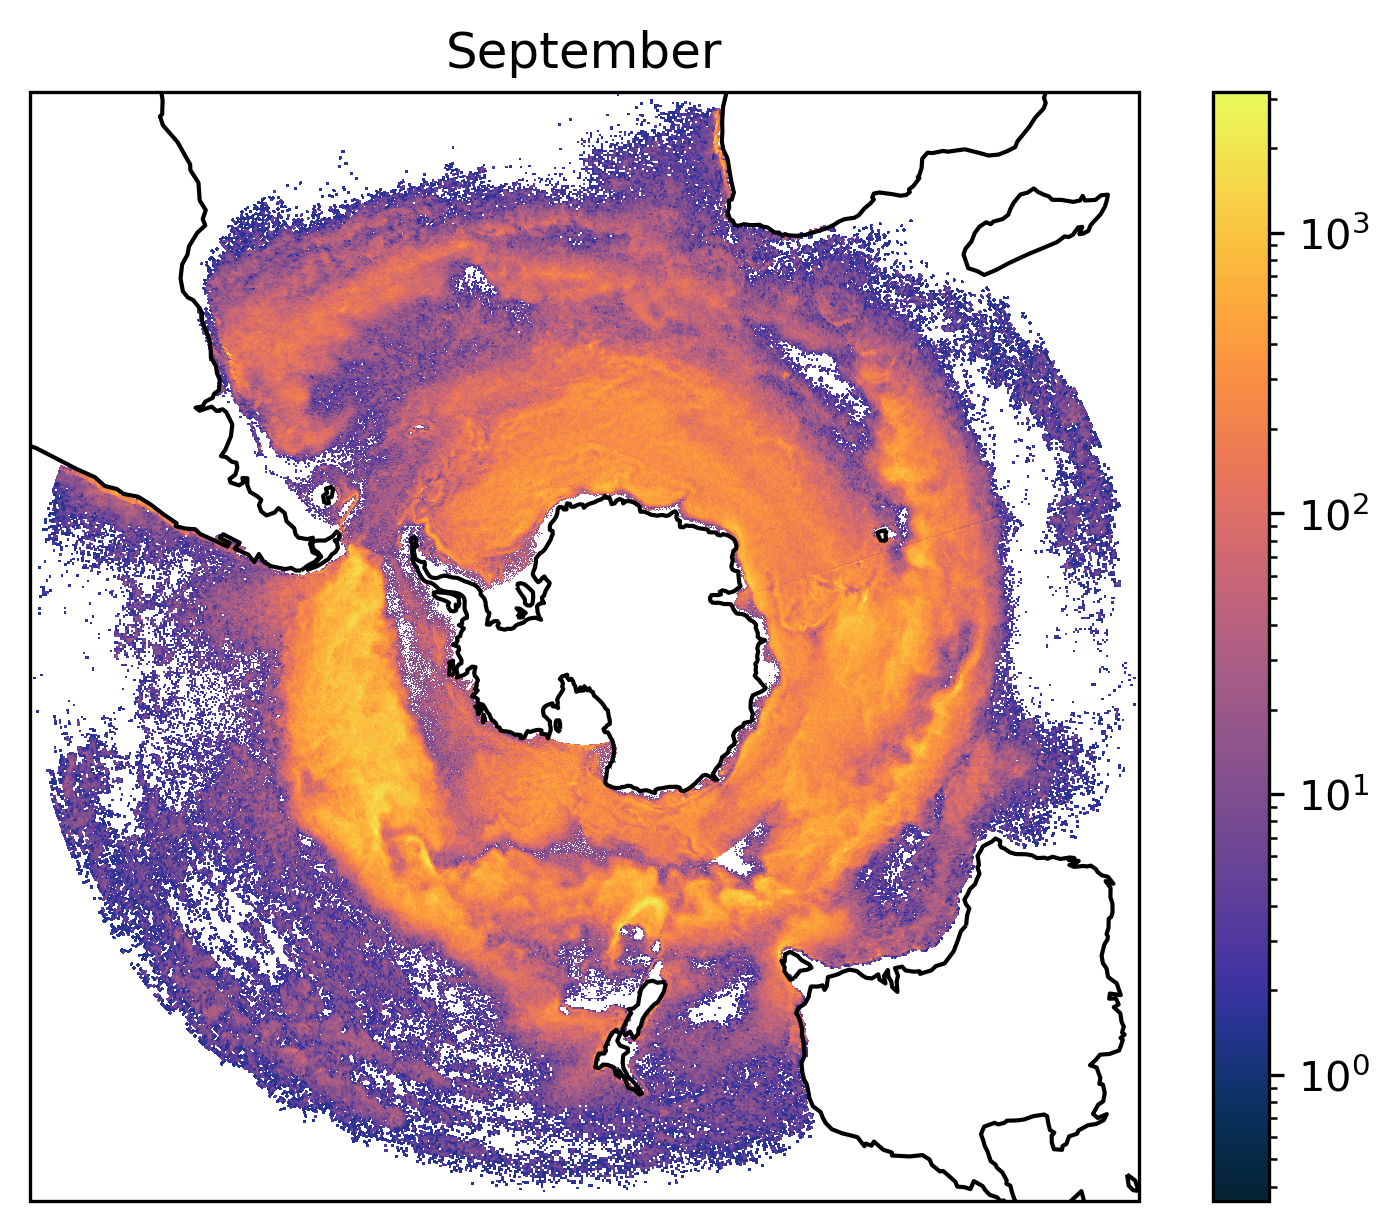

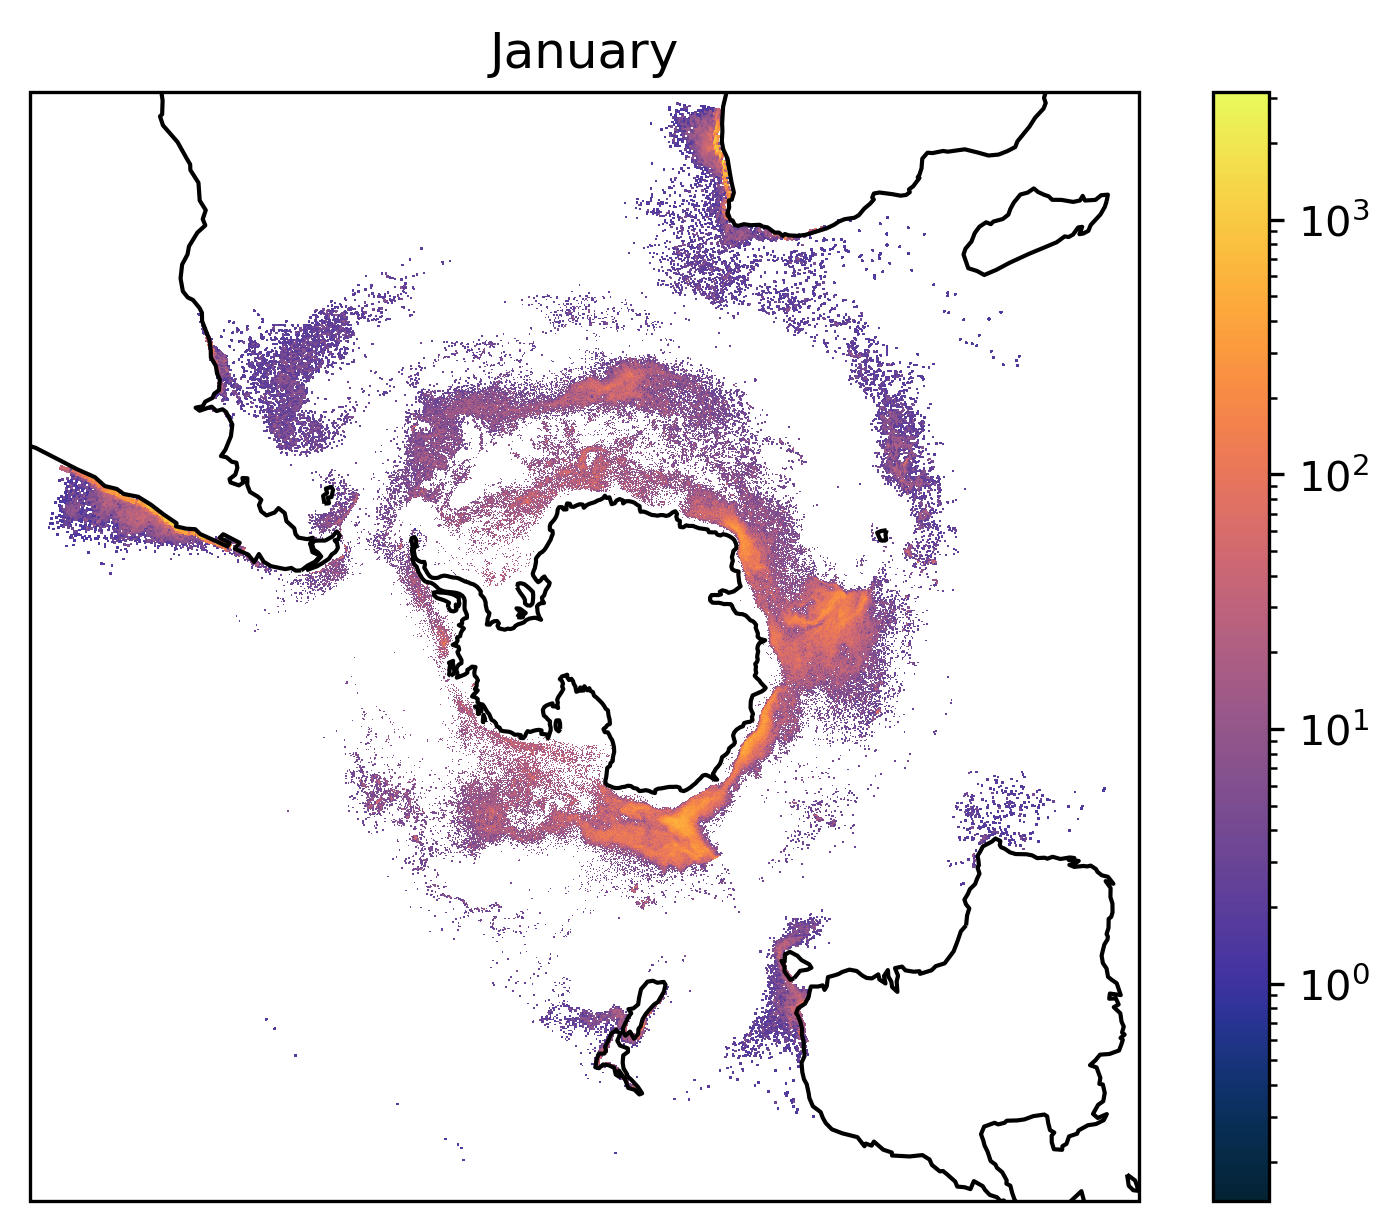

In [22]:
df_late = df_vent[df_vent['year_o']>1983]
df = df_late[(df_late['month_o']>=8)& (df_late['month_o']<=10)]
df = df[['binnedx_o','binnedy_o','subvol_o']]
# Group together data which ventilated in the same horizontal grid cell (same combination of binnedx and binnedy)
df_group = df.groupby( ['binnedx_o','binnedy_o'])
# Calculate total volume in each grid cell
vol_xy = df_group.sum("subvol_o").compute()
plot_norm(ds_domain, vol_xy,'subvol_o')
plt.title('September')
plt.plot()


df = df_late[(df_late['month_o']==12)|(df_late['month_o']<=3) ]

df = df[['binnedx_o','binnedy_o','subvol_o']]
# Group together data which ventilated in the same horizontal grid cell (same combination of binnedx and binnedy)
df_group = df.groupby( ['binnedx_o','binnedy_o'])
# Calculate total volume in each grid cell
vol_xy = df_group.sum("subvol_o").compute()
plot_norm(ds_domain, vol_xy,'subvol_o')
plt.title('January')
plt.plot()

In [45]:
###Age of ventilated water
# group by x,y
# plot mean age

df = df_vent[['binnedx_o','binnedy_o','time_o']]
df_group = df.groupby( ['binnedx_o','binnedy_o'])
count = df_group.mean("time_o").compute()



(<Figure size 1920x1440 with 2 Axes>, <GeoAxes: >)

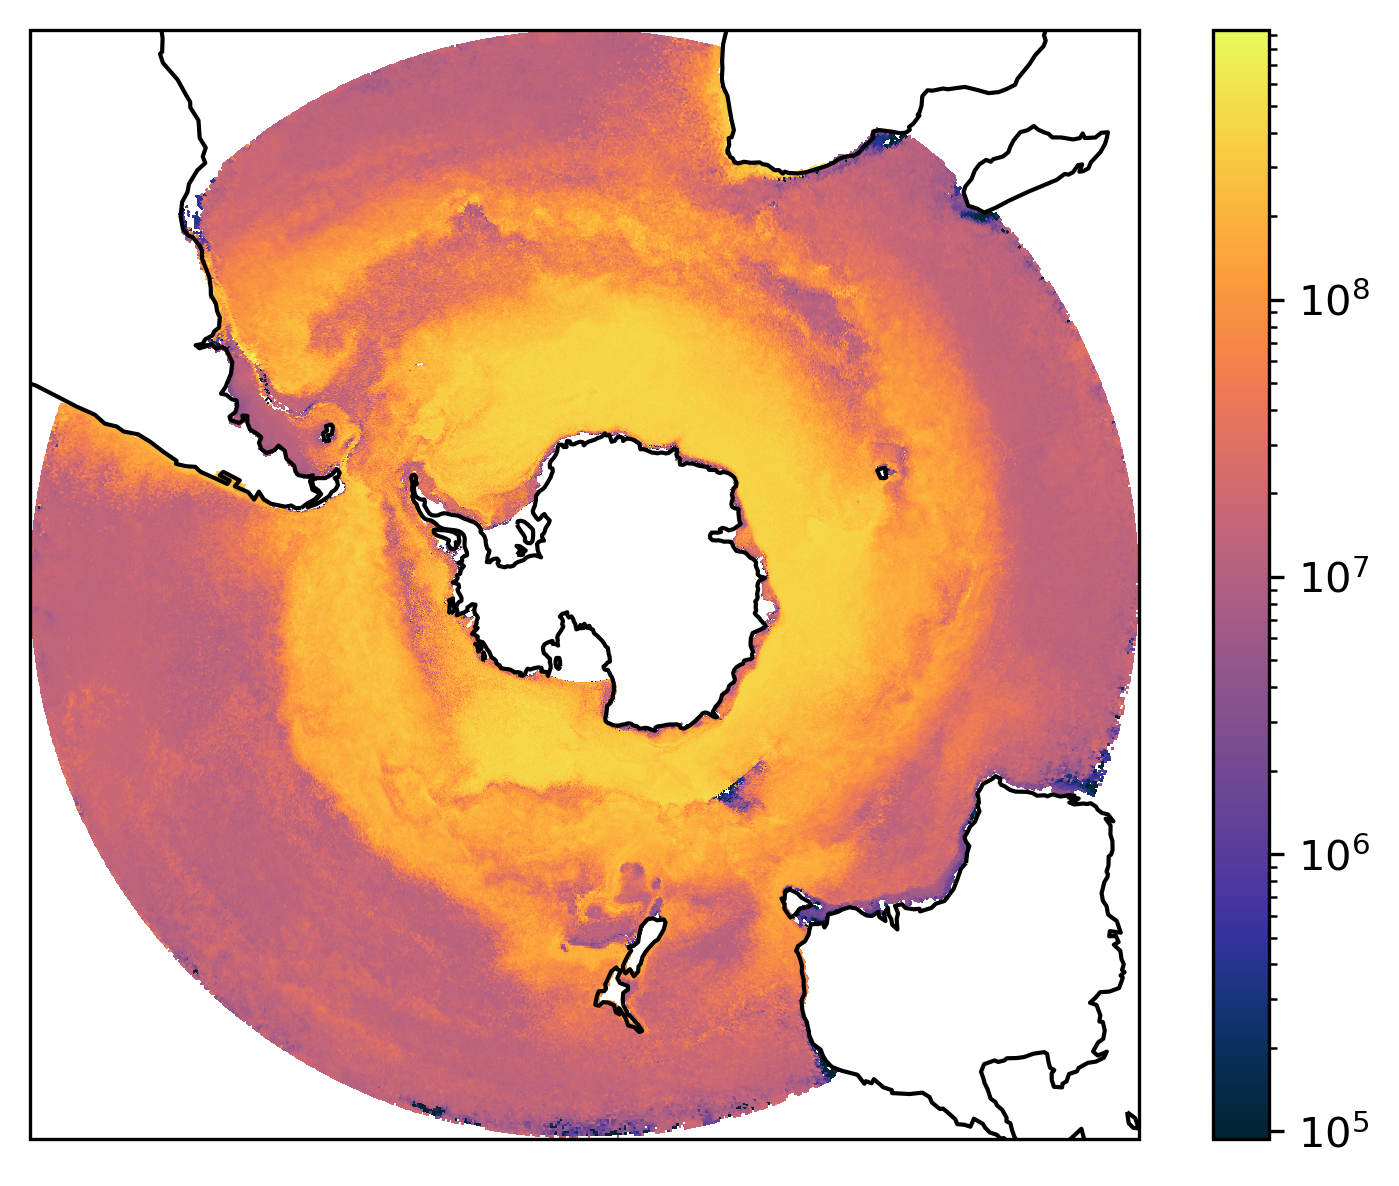

In [46]:
plot(ds_domain, count, "time_o")

In [ ]:
##Now by month

[]

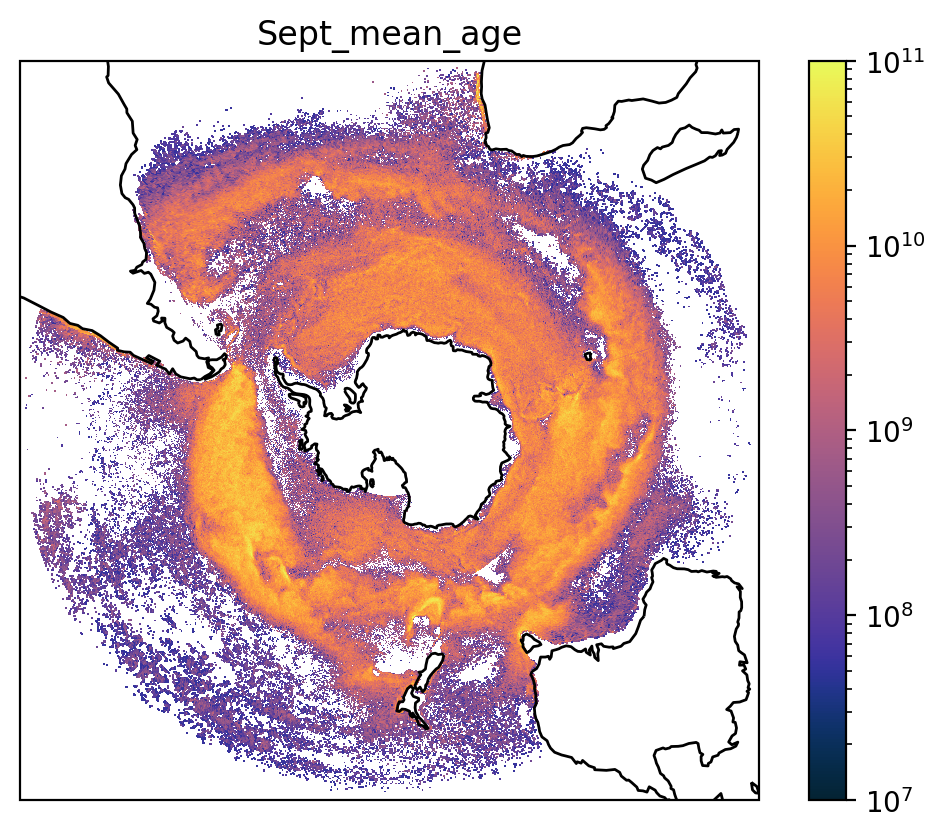

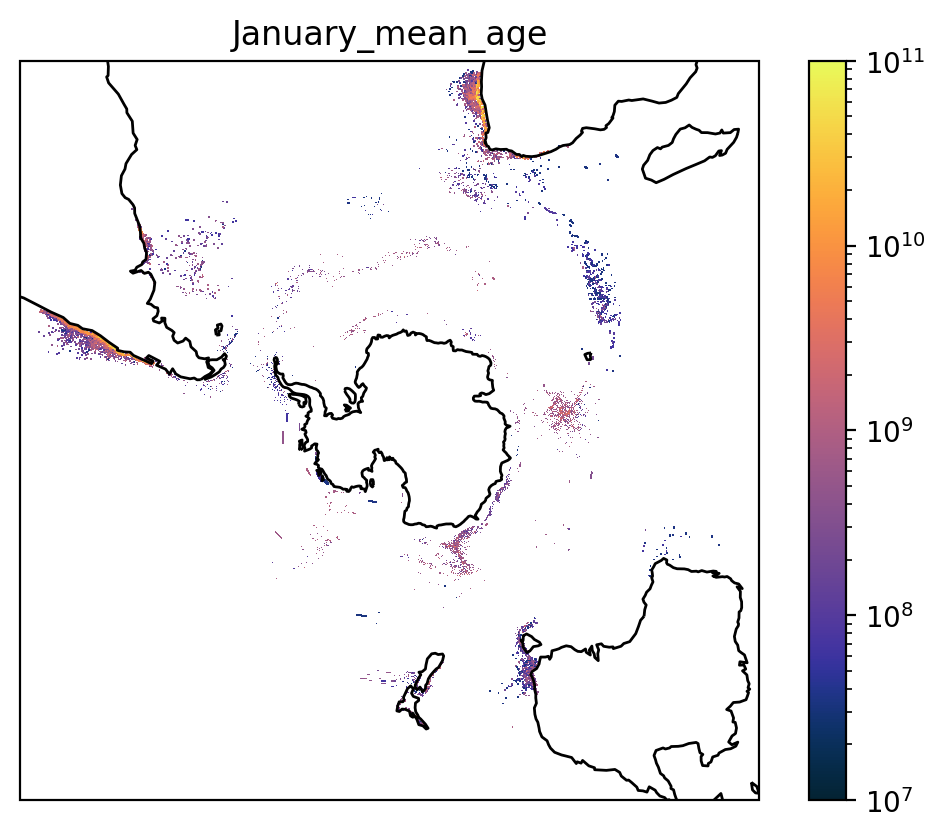

In [15]:
df_late = df_vent[df_vent['year_o']>1983]
df = df_late[df_vent['month_o']==9]
df = df[['binnedx_o','binnedy_o','time_o']]
# Group together data which ventilated in the same horizontal grid cell (same combination of binnedx and binnedy)
df_group = df.groupby( ['binnedx_o','binnedy_o'])
# Calculate total volume in each grid cell
vol_xy = df_group.sum("time_o").compute()
plot(ds_domain, vol_xy,'time_o',vmax = 1e11)
plt.title('Sept_mean_age')
plt.plot()


df = df_late[(df_vent['month_o']==1)]

df = df[['binnedx_o','binnedy_o','time_o']]
# Group together data which ventilated in the same horizontal grid cell (same combination of binnedx and binnedy)
df_group = df.groupby( ['binnedx_o','binnedy_o'])
# Calculate total volume in each grid cell
vol_xy = df_group.sum("time_o").compute()
plot(ds_domain, vol_xy,'time_o',vmax = 1e11)
plt.title('January_mean_age')
plt.plot()

[]

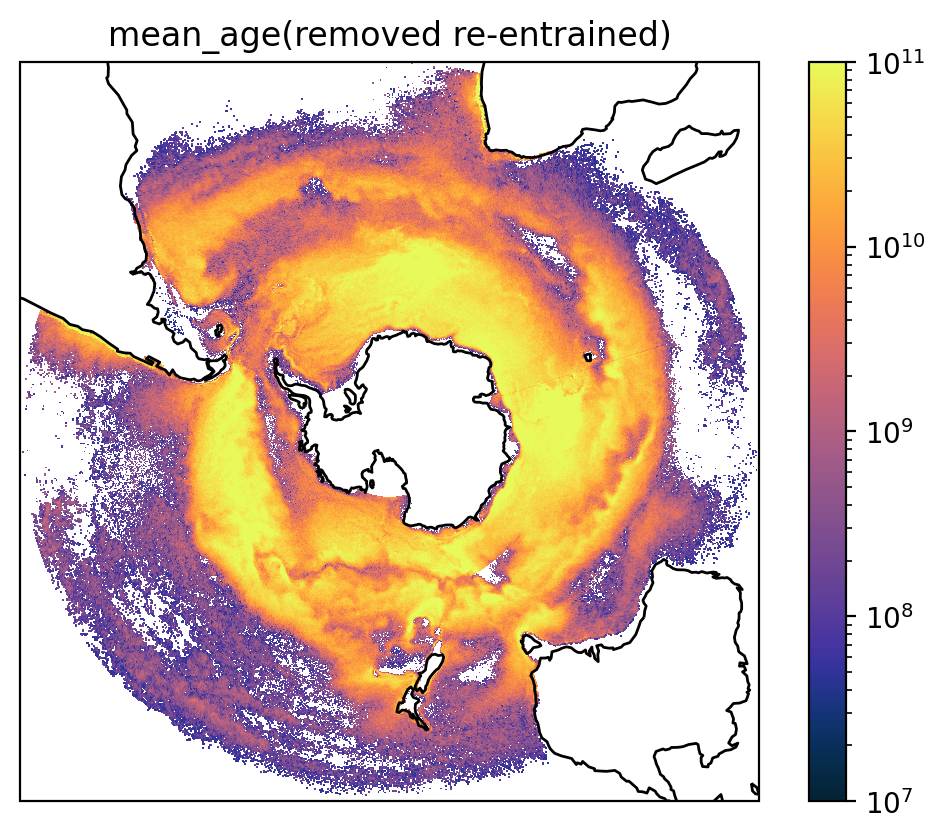

In [24]:
df_late = df_vent[df_vent['year_o']>1983]
df = df_late
df = df[['binnedx_o','binnedy_o','time_o']]
# Group together data which ventilated in the same horizontal grid cell (same combination of binnedx and binnedy)
df_group = df.groupby( ['binnedx_o','binnedy_o'])
# Calculate total volume in each grid cell
vol_xy = df_group.sum("time_o").compute()
plot(ds_domain, vol_xy,'time_o',vmax = 1e11)
plt.title('mean_age(removed re-entrained)')
plt.plot()
